In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

In [53]:
INPUT_DATA_DIR = '../../data/processed/'
INPUT_FILE_NAME = 'cleaned_squashed15_final.parquet'
OUT_DATA_DIR = '../../data/processed/'

In [3]:
df = pd.read_parquet(INPUT_DATA_DIR + INPUT_FILE_NAME)
df.head()

,speaker,headline,description,duration,tags,transcript,WC,clean_transcript,clean_transcript_string,sim_tags,squash15_tags
0,Al Gore,Averting the climate crisis,With the same humor and humanity he exuded in ...,0:16:17,"cars,alternative energy,culture,politics,scien...","0:14\r\r\rThank you so much, Chris.\rAnd it's ...",2281.0,"[thank, chris, truly, great, honor, opportunit...",thank chris truly great honor opportunity come...,"cars,solar system,energy,culture,politics,scie...","culture,politics,science,global issues,technology"
1,Amy Smith,Simple designs to save a life,Fumes from indoor cooking fires kill more than...,0:15:06,"MacArthur grant,simplicity,industrial design,a...","0:11\r\r\rIn terms of invention,\rI'd like to ...",2687.0,"[term, invention, like, tell, tale, favorite, ...",term invention like tell tale favorite project...,"macarthur grant,simplicity,design,solar system...","design,global issues"
2,Ashraf Ghani,How to rebuild a broken state,Ashraf Ghani's passionate and powerful 10-minu...,0:18:45,"corruption,poverty,economics,investment,milita...","0:12\r\r\rA public, Dewey long ago observed,\r...",2506.0,"[public, dewey, long, ago, observe, constitute...",public dewey long ago observe constitute discu...,"corruption,inequality,science,investment,war,c...","science,culture,politics,global issues,business"
3,Burt Rutan,The real future of space exploration,"In this passionate talk, legendary spacecraft ...",0:19:37,"aircraft,flight,industrial design,NASA,rocket ...","0:11\r\r\rI want to start off by saying, Houst...",3092.0,"[want, start, say, houston, problem, enter, se...",want start say houston problem enter second ge...,"flight,design,nasa,science,invention,entrepren...","design,science,business"
4,Chris Bangle,Great cars are great art,American designer Chris Bangle explains his ph...,0:20:04,"cars,industrial design,transportation,inventio...","0:12\r\r\rWhat I want to talk about is, as bac...",3781.0,"[want, talk, background, idea, car, art, actua...",want talk background idea car art actually mea...,"cars,design,transportation,invention,technolog...","design,technology,business,science"


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words="english",
                        use_idf=True,
                        ngram_range=(1,1)) # considering only 1-grams
#                         min_df = 0.05,     # cut words present in less than 5% of documents
#                         max_df = 0.3)      # cut words present in more than 30% of documents 
t0 = time()

tfidf = vectorizer.fit_transform(df['clean_transcript_string'])
print("done in %0.3fs." % (time() - t0))

done in 1.747s.


In [29]:
from sklearn.decomposition import NMF

t1 = time()

n_topics = 15
nmf = NMF(n_components=n_topics,random_state=0)

topics = nmf.fit_transform(tfidf)
top_n_words = 5
t_words, word_strengths = {}, {}
for t_id, t in enumerate(nmf.components_):
    t_words[t_id] = [vectorizer.get_feature_names()[i] for i in t.argsort()[:-top_n_words - 1:-1]]
    word_strengths[t_id] = t[t.argsort()[:-top_n_words - 1:-1]]
print("done in %0.3fs." % (time() - t1))

done in 12.646s.


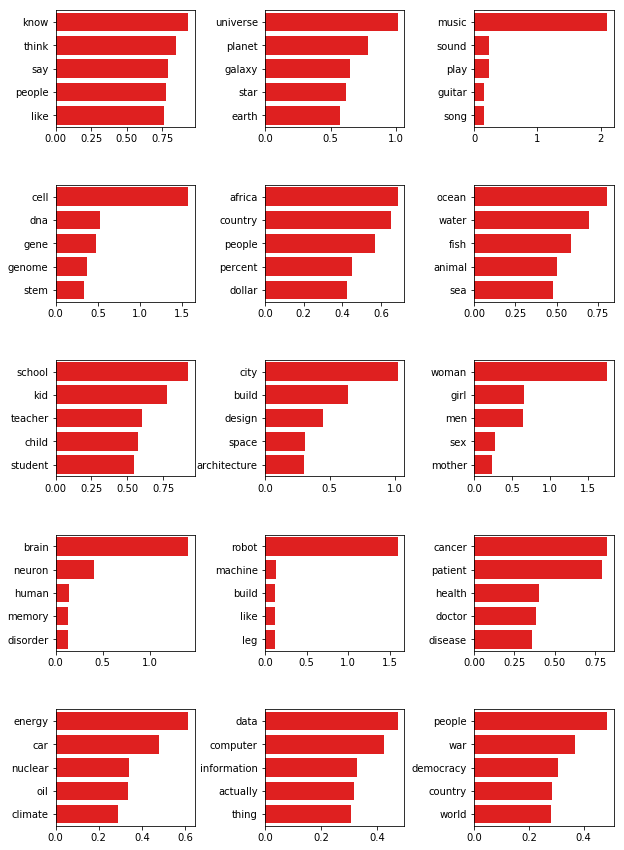

In [31]:
fig, ax = plt.subplots(figsize=(10,15), ncols=3, nrows=5)
plt.subplots_adjust(
    wspace  =  0.5,
    hspace  =  0.5
)
c=0
for row in range(0,5):
    for col in range(0,3):
        sns.barplot(x=word_strengths[c], y=t_words[c], color="red", ax=ax[row][col])
        c+=1
plt.show()

In [32]:
# Formulating a pipeline to insert a document and extract the topics pertinency
from sklearn.pipeline import Pipeline
pipe = Pipeline([
    ('tfidf', vectorizer),
    ('nmf', nmf)
])

# take second element for sort
def takeSecond(elem):
    return elem[1]


In [41]:
def predict_best_topics_processed_string(string):
    t = pipe.transform([string])
    rev_topics = np.where(t>0.0015)[1]
    rev_topics_score = t[0][rev_topics]

    rev_topscore = list(zip(rev_topics,rev_topics_score))
    rev_topscore.sort(key = takeSecond, reverse = True)
    return rev_topscore

def predict_best_topics_doc(df,did):
    string = df['transcript'].iloc[did]
    
    return predict_best_topics_processed_string(string)

In [9]:
def show_best_topics_doc(did):

    print('For document #'+str(did)+'...')

    rev_topscore = predict_best_topics_doc(did)
    
    print('\nAll relevant topics (in order of descending relevance): \n')
    for top in range(len(rev_topscore)):
        print(t_words[rev_topscore[top][0]])

    print('\nTranscript:\n',df['transcript'].iloc[document_id][:500],'...')
    print('\nTrue tags from ted_main.csv: \n',df['tags'].iloc[document_id])
    
def show_best_topics_string(string):
    rev_topscore = predict_best_topics_processed_string(string)
#     print(rev_topscore)
#     print('\nAll relevant topics (in order of descending relevance): \n')
    all_topics = []
    for top in range(len(rev_topscore)):
#         print(t_words[rev_topscore[top][0]],rev_topscore[top][0])
        all_topics.append(rev_topscore[top][0])
    return all_topics

In [10]:
# correct = 0
# total = len(df.index)
# all_tags = []
# for tr in range(total):
#     print(tr)
#     rev_topscore = predict_best_topics_doc(tr)
#     if rev_topscore != []: 
#         topic_tags = t_words[rev_topscore[0][0]]
#         given_tags = df['tags'][tr]
#     #     print(topic_tags)
#     #     print(given_tags)
#         for label in given_tags:
#             if label not in all_tags:
#                 all_tags.append(label)
        
#         for word in topic_tags:
#             if word in given_tags:
#                 correct += 1


# print('Correct', correct)
# percentage_correct = (correct/len(all_tags))
# print('Percentage correct',percentage_correct)

In [11]:
# def predict_tags(rev_topscore, threshold):
#     relevant_topics = rev_topscore
#     if relevant_topics == []:
#         print('No relevant topics, unable to predict tags')
#         return

#     all_word_score = []
#     for top in range(len(relevant_topics)):
#         topic = t_words[rev_topscore[top][0]]
#         score = rev_topscore[top][1]
#         weights = word_strengths[rev_topscore[top][0]]
#         combined_score = [0]*len(weights)
#         for i in range(len(weights)):
#             combined_score[i]= weights[i]*score
#         word_score = list(zip(topic,combined_score))
#         all_word_score += word_score
#     all_word_score.sort(key = takeSecond, reverse = True)
    
#     final_tags = []
#     for pair in all_word_score:
#         if pair[1] > threshold:
#             final_tags.append(pair[0])
#     return final_tags

In [12]:
# def predict_accuracy(df):
#     correct = 0
#     total = len(df.index)
# #     total = 1
#     all_tags = []
#     tag_count = 0
#     threshold = 0
#     taggable = 0
#     empty = 0
# #     print(squash_list)
# #     print('should have printed')
#     for tr in range(total):
#         if tr%100 == 0:
#             print(tr)
#         tagged = False
#         predicted_tags = predict_tags(predict_best_topics_doc(df,tr),threshold)
#         given_tags = df['tags'][tr]
# #         print(given_tags)
#         squash = []
#         for label in given_tags:
# #             print(label)
#             if label in squash_list:
# #                 print(label)
#                 squash.append(label)
#                 tag_count += 1
#                 if label not in all_tags:
#                     all_tags.append(label)
#         left = False
#         for squish in squash_list:
#             if squish in given_tags:
#                 left = True
                    
#         if predicted_tags != None:
#             for word in predicted_tags:
#                 if word in squash:
#                     tagged = True
#                     correct += 1
#         if tagged:
#             taggable += 1
        
#         if not left:
#             empty += 1
            
#     print(all_tags.sort() == squash_list.sort())
#     print('Taggable:', taggable)
#     print('Tag count:', tag_count)
#     print('Percentage tagged:',taggable/total)
#     percentage_correct_tag_count = (correct/tag_count)
#     print('Percentage correct (tag_count):',percentage_correct_tag_count)


In [13]:
# def predict_tags_input(threshold):
#     string = input()
#     predicted = predict_tags(predict_best_topics_processed_string(string),threshold)
#     print(predicted)

In [14]:
def count_tags(tag_column):
    tags = tag_column.str.replace(', ', ',').str.lower().str.strip()
    joined_tags = tags.str.cat(sep=',').split(',')
    all_tags_w_dup = pd.Series(joined_tags)

    tag_counts = all_tags_w_dup.value_counts()
    tag_list = list(tag_counts.index)
    return tag_counts, tag_list

In [15]:
tags, tag_list = count_tags(df['squash15_tags'])
tags

science          1467
culture          1155
technology        787
global issues     679
design            477
history           385
business          349
entertainment     285
media             279
biomechanics      220
future            218
biodiversity      218
humanity          217
politics          199
communication     185
dtype: int64

In [42]:
tag_topic = {}
for i in range(len(tag_list)):
    tag = tag_list[i]
#     print(tag)
    all_topics = show_best_topics_string(tag)
#     print(all_topics)
    tag_topic[tag] = all_topics
print(tag_topic)

{'science': [1, 6, 3, 13, 9], 'culture': [14, 3, 7, 8, 2, 6], 'technology': [13, 12, 3], 'global issues': [14, 12, 4], 'design': [7, 13], 'history': [14, 1], 'business': [4], 'entertainment': [13, 10, 2, 8], 'media': [], 'biomechanics': [10], 'future': [12, 14, 3, 10, 6, 1, 13], 'biodiversity': [5], 'humanity': [14, 1, 8], 'politics': [14], 'communication': [13, 14, 9]}


In [43]:
empty_tags = []
for k,v in tag_topic.items():
    if v == []:
        print(k)
        empty_tags.append(k)
print(len(empty_tags))

media
1


In [ ]:
def predict_best_topics_processed_string(string):
    t = pipe.transform([string])
    rev_topics = np.where(t>0.0015)[1]
    rev_topics_score = t[0][rev_topics]

    rev_topscore = list(zip(rev_topics,rev_topics_score))
    rev_topscore.sort(key = takeSecond, reverse = True)
    return rev_topscore

In [44]:
string = 'science'
t = pipe.transform([string])
print(t)

[[0.         0.03219693 0.         0.00681816 0.         0.
  0.01222996 0.         0.         0.00156243 0.         0.
  0.         0.00483603 0.        ]]


In [48]:
matrix = np.empty((len(tag_list),len(tag_list)))
for i in range(len(tag_list)):
    tag = tag_list[i]
    t = pipe.transform([tag])
    matrix[i] = t
transposed_matrix = np.transpose(matrix)

In [49]:
df1 = df.copy()
for i in range(len(tag_list)):
    topic_name = 'topic'+str(i)
    df1[topic_name] = pd.Series(transposed_matrix[i].tolist())
df1

,speaker,headline,description,duration,tags,transcript,WC,clean_transcript,clean_transcript_string,sim_tags,...,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14
0,Al Gore,Averting the climate crisis,With the same humor and humanity he exuded in ...,0:16:17,"cars,alternative energy,culture,politics,scien...","0:14\r\r\rThank you so much, Chris.\rAnd it's ...",2281.0,"[thank, chris, truly, great, honor, opportunit...",thank chris truly great honor opportunity come...,"cars,solar system,energy,culture,politics,scie...",...,0.000000,0.012230,0.000000,0.000000,0.001562,0.000000,0.0,0.000000,0.004836,0.000000
1,Amy Smith,Simple designs to save a life,Fumes from indoor cooking fires kill more than...,0:15:06,"MacArthur grant,simplicity,industrial design,a...","0:11\r\r\rIn terms of invention,\rI'd like to ...",2687.0,"[term, invention, like, tell, tale, favorite, ...",term invention like tell tale favorite project...,"macarthur grant,simplicity,design,solar system...",...,0.000000,0.001854,0.005125,0.002454,0.000472,0.000000,0.0,0.000000,0.000000,0.021417
2,Ashraf Ghani,How to rebuild a broken state,Ashraf Ghani's passionate and powerful 10-minu...,0:18:45,"corruption,poverty,economics,investment,milita...","0:12\r\r\rA public, Dewey long ago observed,\r...",2506.0,"[public, dewey, long, ago, observe, constitute...",public dewey long ago observe constitute discu...,"corruption,inequality,science,investment,war,c...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.032121,0.075614,0.000000
3,Burt Rutan,The real future of space exploration,"In this passionate talk, legendary spacecraft ...",0:19:37,"aircraft,flight,industrial design,NASA,rocket ...","0:11\r\r\rI want to start off by saying, Houst...",3092.0,"[want, start, say, houston, problem, enter, se...",want start say houston problem enter second ge...,"flight,design,nasa,science,invention,entrepren...",...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.016062,0.000000,0.034169
4,Chris Bangle,Great cars are great art,American designer Chris Bangle explains his ph...,0:20:04,"cars,industrial design,transportation,inventio...","0:12\r\r\rWhat I want to talk about is, as bac...",3781.0,"[want, talk, background, idea, car, art, actua...",want talk background idea car art actually mea...,"cars,design,transportation,invention,technolog...",...,0.000000,0.000000,0.114847,0.000000,0.000000,0.000000,0.0,0.000000,0.032952,0.000000
5,Craig Venter,Sampling the ocean's DNA,Genomics pioneer Craig Venter takes a break fr...,0:16:51,"biotech,invention,oceans,genetics,DNA,biology,...","0:11\r\r\rAt the break, I was asked by several...",2548.0,"[break, ask, people, comment, age, debate, com...",break ask people comment age debate comment un...,"biotech,invention,oceans,biomechanics,science,...",...,0.000511,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.027652
6,David Pogue,Simplicity sells,New York Times columnist David Pogue takes aim...,0:21:26,"simplicity,computers,software,interface design...","0:12\r\r\r(Music: ""The Sound of Silence,""\rSim...",3584.0,"[music, sound, silence, simon, garfunkel, hell...",music sound silence simon garfunkel hello voic...,"simplicity,computers,software,design,music,med...",...,0.000000,0.000000,0.000000,0.000180,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
7,David Rockwell,A memorial at Ground Zero,In this emotionally charged conversation with ...,0:24:37,"New York,memory,interview,death,culture,archit...","0:13\r\r\rKurt Andersen: Like many architects,...",4008.0,"[kurt, andersen, like, architect, david, hog, ...",kurt andersen like architect david hog limelig...,"new york,memory,interview,death,culture,archit...",...,0.000000,0.000000,0.000000,0.001933,0.000000,0.003064,0.0,0.000000,0.003725,0.000000
8,Dean Kamen,To invent is to give,Inventor Dean Kamen lays out his argument for ...,0:20:07,"robots,cars,industrial design,transportation,i...","0:11\r\r\rAs you pointed out, every tim

In [54]:
df1.to_parquet(OUT_DATA_DIR+'final_squash15_with_pos_ner_tm.parquet')

In [56]:
!pip install joblib

In [57]:
import joblib

In [60]:
joblib.dump(nmf, '../../models/nmf15.joblib')

['../../models/nmf15.joblib']

In [59]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.
